## First contact with dense_basis and the GP-SFH module:

Creating different shapes using SFH-tuples

In [51]:
import numpy as np
import dense_basis as db
import matplotlib.pyplot as plt

In [52]:
Nparam = 1
redshift = 1.0
logMstar = 10.0

Let’s start with an SFH that is rising throughout a galaxy’s lifetime, such as may be expected for high-redshift star forming galaxies. Since we are considering a galaxy with 𝑀∗=10^10𝑀⊙

Since the SFR is rising, we also choose a short t50, since it is rapidly building forming its stars. Running this through the model, we get:

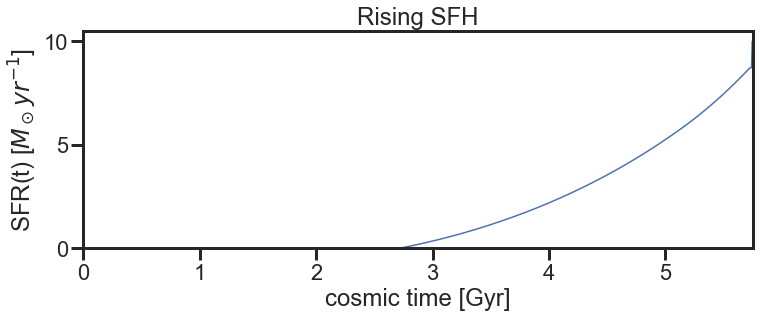

In [53]:
logSFR = 1.0
t50 = 0.6 # t50, lookback time, in Gyr

sfh_tuple = np.hstack([logMstar, logSFR, Nparam, db.scale_t50(t50,redshift)])
sfh, timeax = db.tuple_to_sfh(sfh_tuple, redshift) #timeax in Gyr, SFH in Msun/Yr

fig = db.plot_sfh(timeax, sfh, lookback=False) #notice if lookback or cosmic time
plt.title('Rising SFH')
plt.show()

#notice the SFH is limited in age because of the selected redshift

Check https://dense-basis.readthedocs.io/en/latest/tutorials/the_gp_sfh_module.html for getting more prototype SFHs

In [54]:
print(sfh)
print(timeax)

[0.00000000e+00 3.28961263e-03 5.10951945e-03 5.97135304e-03
 5.87510098e-03 4.82074423e-03 2.80826061e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

Let's get random SFHs (because I don't want to select always the parameters).


The next step is to generate a template atlas that you will use for fitting. The advantage of doing this is that we trade time-complexity for space, which is usually much more abundant, and it only needs to be done once to fit a large dataset. Before doing this, however, we need a set of priors that we can draw from to generate this atlas. This is done using the db.Priors() class:

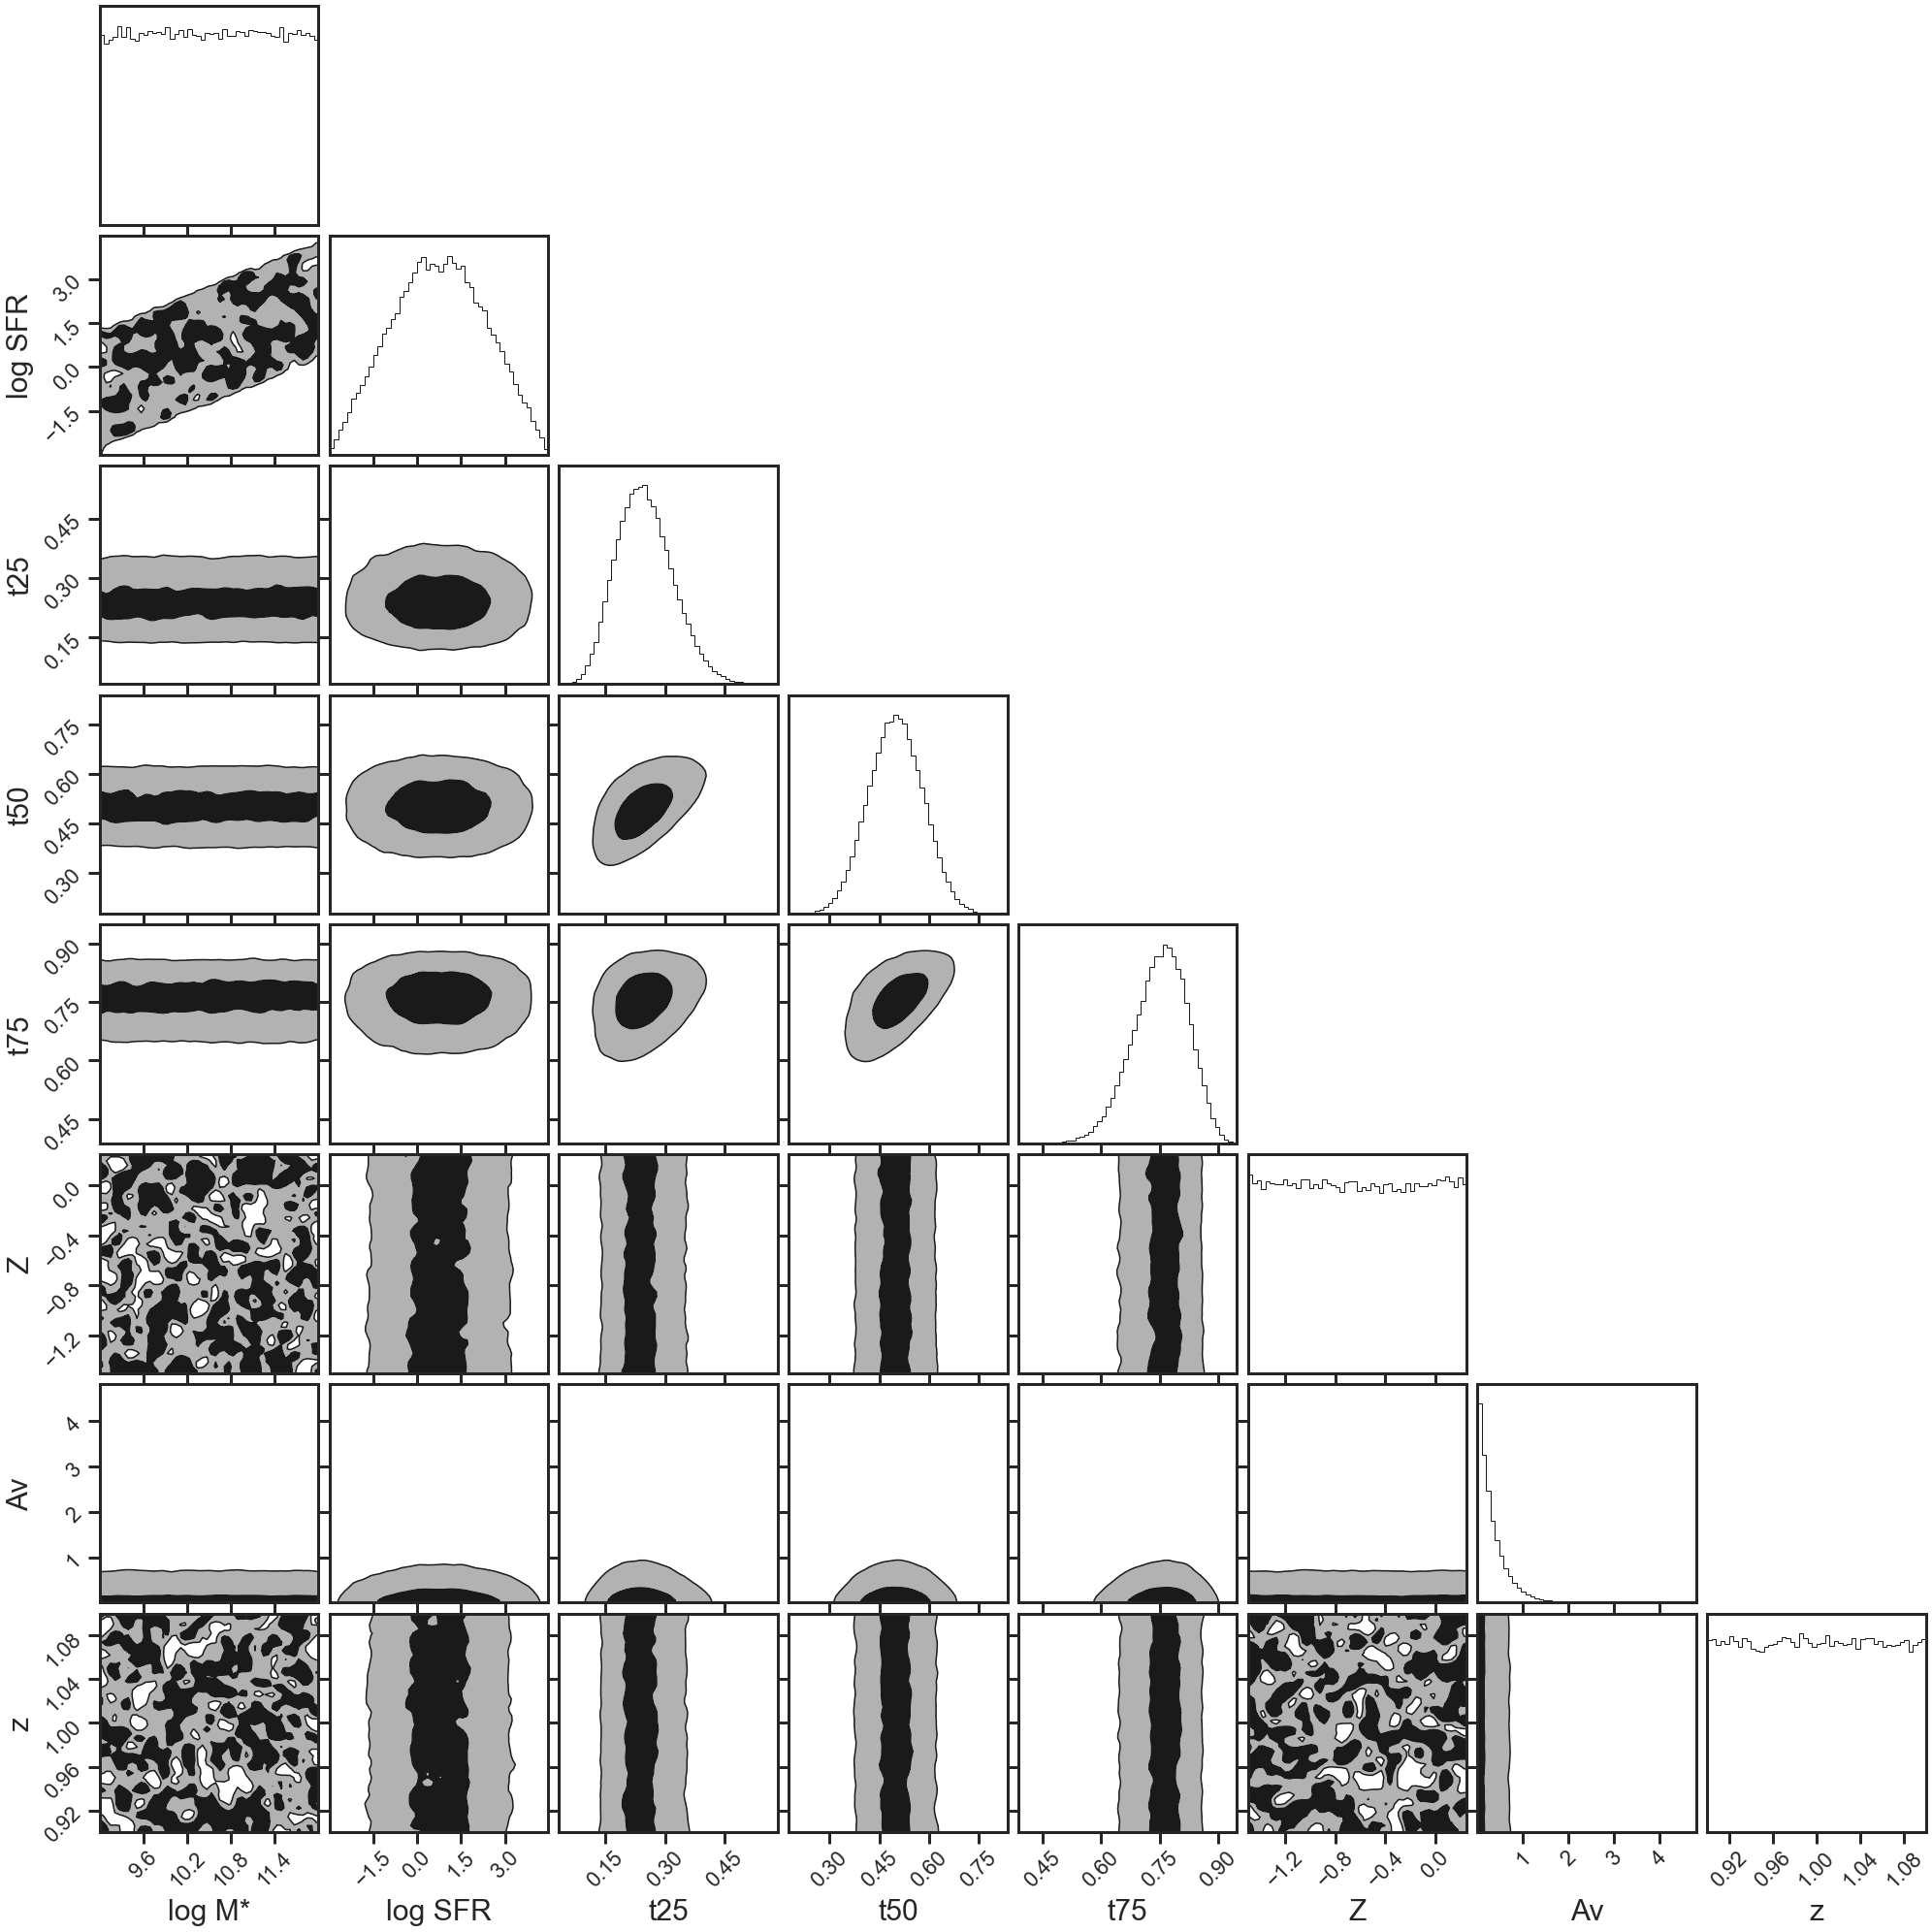

In [55]:
priors = db.Priors()
priors.tx_alpha = 3.0 
priors.plot_prior_distributions()


#tx : lookback times at which a galaxy formed certain fractions of its mass
#concentration (tx_alpha) and number of parameters (Nparam) of distribution

Let’s generate a mock star formation history (SFH) to recover. This can be done by sampling our priors for an SFH-tuple and then converting it to a SFR-vs-time curve using the db.tuple_to_sfh() command.

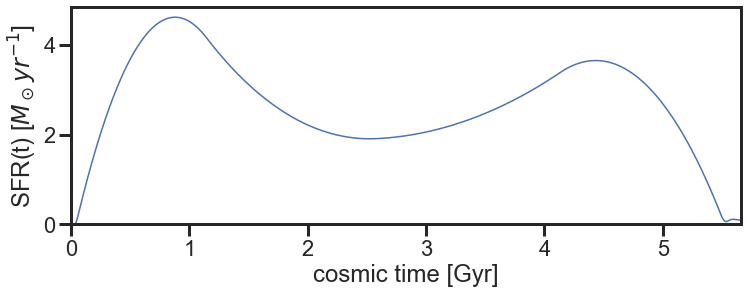

In [40]:
# sample from the prior space to get parameters
rand_sfh_tuple, rand_Z, rand_Av, rand_z = priors.sample_all_params(random_seed = np.random.randint(1000))

# generate an SFH corresponding to the SFH-tuple and see how it looks:

rand_sfh, rand_time = db.tuple_to_sfh(rand_sfh_tuple, zval = rand_z)
fig = db.plot_sfh(rand_time, rand_sfh, lookback=False)
sfh_truths = [rand_time, rand_sfh]

Now we just want to generate the sfh_tuple, as in our task, at this point, we do not care about redshift (always z=0.0), nor the attentuation (Av=0), we might care about metallicity Z in future (now we are using Z=0.0198 in our SNPE model). 

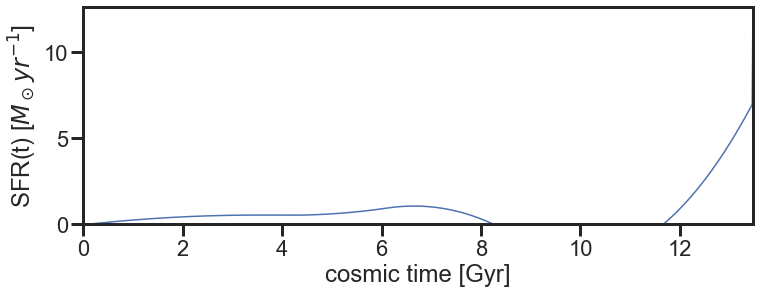

In [75]:
# sample from the prior space to get tuple
rand_sfh_tuple=priors.sample_sfh_tuple()
rand_sfh_tuple[0]=10.0 #logMstar at selected z (in this case z=0)
rand_sfh, rand_time = db.tuple_to_sfh(rand_sfh_tuple, zval = 0.0) 
fig = db.plot_sfh(rand_time, rand_sfh, lookback=False) #notice max age is 13.5 Gyrs
sfh_truths = [rand_time, rand_sfh]

In [76]:
#print(rand_sfh,rand_time)

print(format(np.sum(rand_sfh)*(rand_time[1]-rand_time[0])*10**9,'1E'))
#notice we are doing Msun/Yr * Gyr * 1e9 so we obtain Msun
#we check the total stellar mass at z=0 is 10**10 (as in our parametric SFHs)

#we confirm the time steps are always the same
print(rand_time[1]-rand_time[0],rand_time[2]-rand_time[1],rand_time[100]-rand_time[99])

1.020915E+10
0.01348046441147335 0.01348046441147335 0.013480464411473214


Let's see if we can get the percentiles (notice we have to change the step of ages and the unit in the SFR). To do that we also need to fix the mass of the non parametric SFHs to 10^10.

In [89]:
def generate_weights_from_SFHs_non_param(n,logMstar=10.0,z=0.0,percen=True):
    priors = db.Priors()
    curves=[]
    times=[] #not needed because if we fix z all rand_time are exactly the same
    for i in range(n):
        rand_sfh_tuple=priors.sample_sfh_tuple()
        rand_sfh_tuple[0]=logMstar #logMstar at selected z (in this case z=0)
        rand_sfh, rand_time = db.tuple_to_sfh(rand_sfh_tuple, zval = z) 
        curves.append(rand_sfh*1e-9) #conversion from Msun/yr to Msun/Gyr
        times.append(rand_time)
    
    ms=[]
    #non accumulative mass curves, we save it cause we will use it later
    for index,curve in enumerate(curves):        
        sfr_0=curve
        m=[]
        t=times[index]
        step=t[1]-t[0]
        for i,tx in enumerate(t):  
             m_t=sfr_0[i]*step #this gives directly the mass curve (non accumulative)
             m.append(m_t)
        ms.append(m/np.sum(m)) #normalized (weigths!!)

    if percen:
        #compute percentiles
        percentiles=[]
        for i,curve in enumerate(curves):
             mcurve=ms[i]
             m=[]
             percent=[]
             for j in range(len(mcurve)):
                m.append(np.sum(mcurve[:j+1]))
             for k in range(1,10):
                ind=np.argmin(abs(np.array(m)-k/10))
                percent.append(t[ind])
             percentiles.append(percent)  
        return np.array(times),np.array(ms),np.array(percentiles)
    else:
        return np.array(times),np.array(ms)

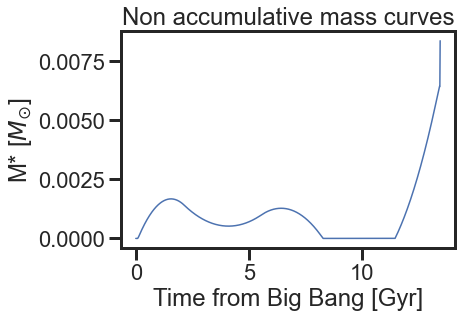

1.0


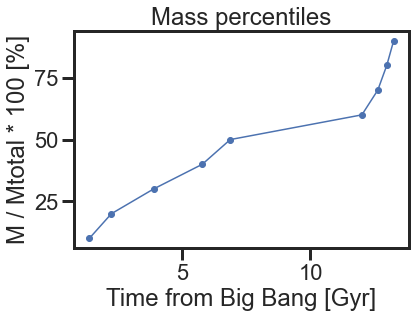

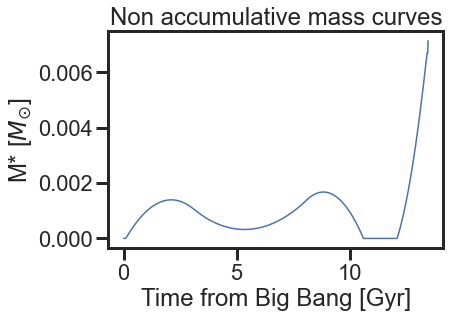

0.9999999999999998


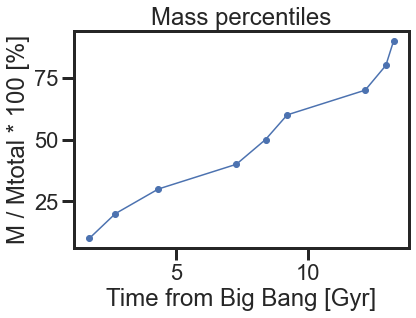

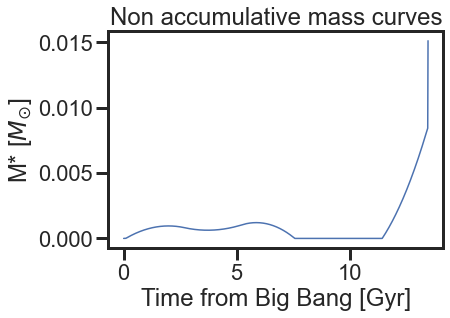

1.0


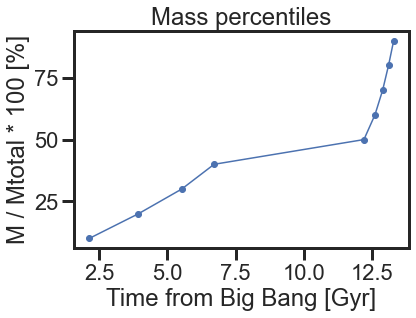

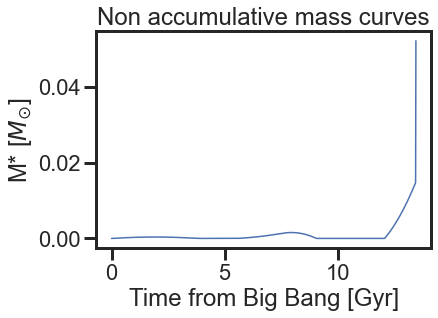

1.0


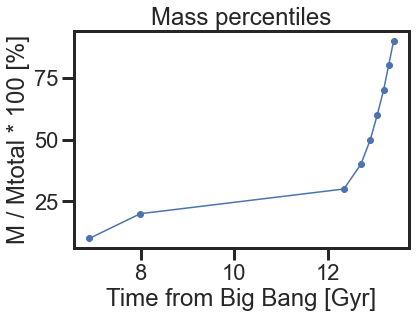

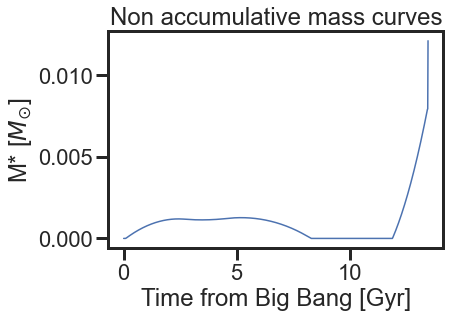

0.9999999999999998


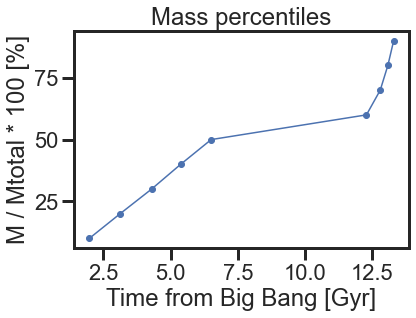

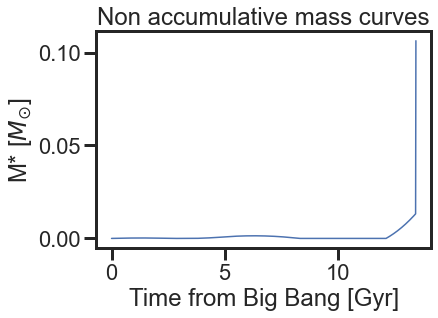

1.0


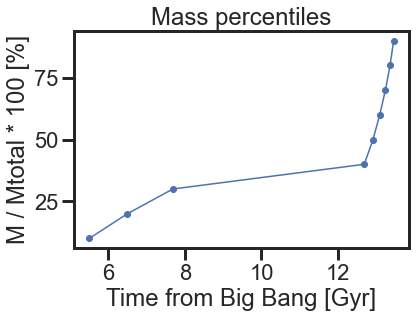

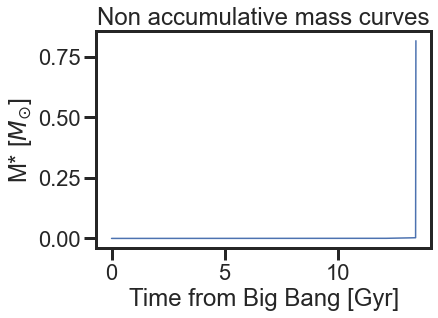

1.0


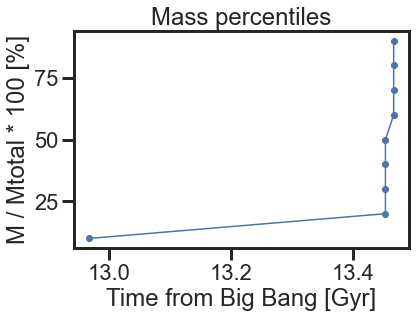

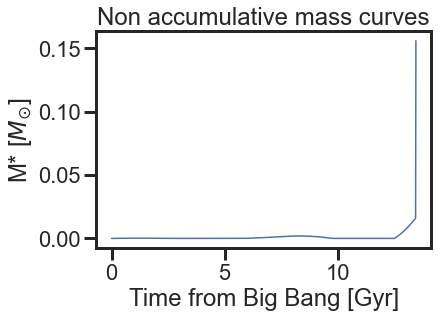

0.9999999999999999


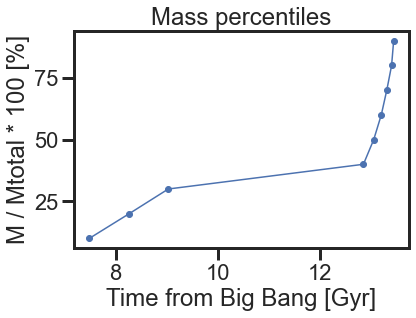

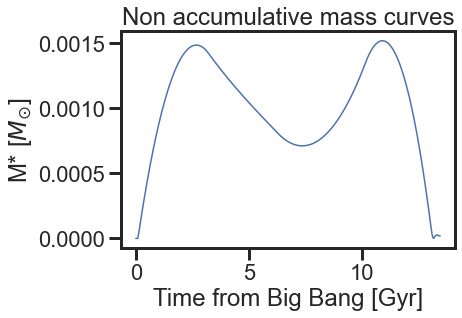

1.0


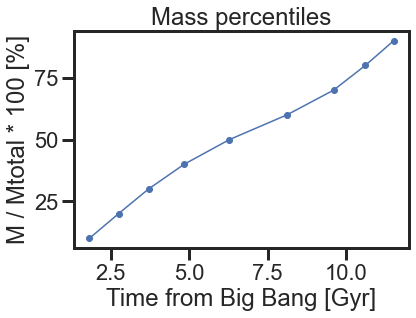

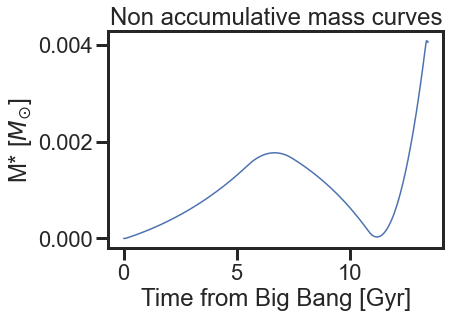

1.0


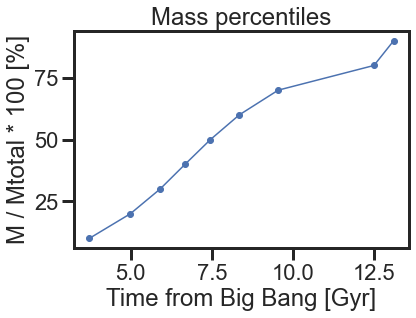

In [92]:
n=10
t,ms,percentiles=generate_weights_from_SFHs_non_param(n)

for i in range(n):
    plt.plot(t[i,:],ms[i,:])
    plt.title('Non accumulative mass curves')
    plt.ylabel('M* [$M_{\\odot}$]')
    plt.xlabel('Time from Big Bang [Gyr]')
    plt.show()
    print(np.sum(ms[i,:]))
    plt.plot(percentiles[i,:],np.arange(10,100,10),'-o')
    plt.title('Mass percentiles')
    plt.xlabel('Time from Big Bang [Gyr]')
    plt.ylabel('M / Mtotal * 100 [%]')
    plt.show()

Now we are ready to check how are models trained with parametric SFHs work with these little babies. Probably not really well, but next step will be to train our model with them so it gets much more flexible.